In [1]:
#preparation
import numpy as np
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from google.colab import files
uploaded = files.upload()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Saving ML_2_Fellow.csv to ML_2_Fellow.csv


In [96]:
#import the file
df=pd.read_csv('ML_2_Fellow.csv',encoding='iso-8859-1')

In [97]:
#cek data description in CSV
print(df.describe())

              Jumlah   Harga_Satuan  Kode_Pelanggan
count  535874.000000  535874.000000   403182.000000
mean        9.587927       4.636533    15287.687868
std       153.292222      97.302232     1714.009551
min    -74215.000000  -11062.060000    12346.000000
25%         1.000000       1.250000    13952.000000
50%         3.000000       2.080000    15152.000000
75%        10.000000       4.130000    16791.000000
max     74215.000000   38970.000000    18287.000000


In [98]:
#cek data head
print(df.head(10))

  Kode_Bayar Kode_Barang  ... Kode_Pelanggan          Negara
0     536365      85123A  ...        17850.0  United Kingdom
1     536365       71053  ...        17850.0  United Kingdom
2     536365      84406B  ...        17850.0  United Kingdom
3     536365      84029G  ...        17850.0  United Kingdom
4     536365      84029E  ...        17850.0  United Kingdom
5     536365       22752  ...        17850.0  United Kingdom
6     536365       21730  ...        17850.0  United Kingdom
7     536366       22633  ...        17850.0  United Kingdom
8     536366       22632  ...        17850.0  United Kingdom
9     536367       84879  ...        13047.0  United Kingdom

[10 rows x 8 columns]


In [99]:
# check type dataFrame
print(pd.DataFrame(df.dtypes))

                         0
Kode_Bayar          object
Kode_Barang         object
Barang              object
Jumlah             float64
Tanggal_Transaksi   object
Harga_Satuan       float64
Kode_Pelanggan     float64
Negara              object


In [100]:
# change Tanggal_Transaksi to date time format
df['Tanggal_Transaksi'] = pd.to_datetime(df['Tanggal_Transaksi'])

In [101]:
# change Kode_Pelanggan to int
df['Kode_Pelanggan'] = pd.to_numeric(df['Kode_Pelanggan'])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


AxesSubplot(0.125,0.125;0.775x0.755)
False


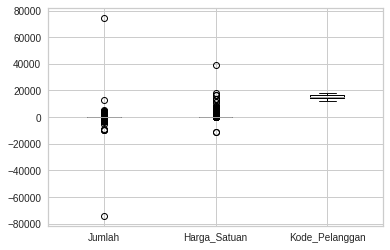

In [102]:
#cek value in data
plt.figure()
print(df.boxplot())
print(df.empty)
#there is a null value and negatif value that resemble cancelation

In [103]:
#Drop value that negatif and null
df = df.dropna().reset_index()
df = df[df.Jumlah <=10000]
df = df[df.Jumlah >=0]

In [104]:
print(df.head()) #check the data

   index Kode_Bayar Kode_Barang  ... Harga_Satuan  Kode_Pelanggan          Negara
0      0     536365      85123A  ...         2.55         17850.0  United Kingdom
1      1     536365       71053  ...         3.39         17850.0  United Kingdom
2      2     536365      84406B  ...         2.75         17850.0  United Kingdom
3      3     536365      84029G  ...         3.39         17850.0  United Kingdom
4      4     536365      84029E  ...         3.39         17850.0  United Kingdom

[5 rows x 9 columns]


In [105]:
#=============Number 1===============
# get the goods with highest order
sum=df.groupby(['Barang']).sum()
print(sum.sort_values(by='Jumlah', ascending=False).head())

                                        index  ...  Kode_Pelanggan
Barang                                         ...                
WORLD WAR 2 GLIDERS ASSTD DESIGNS   132820672  ...       7226036.0
JUMBO BAG RED RETROSPOT             433238912  ...      24748363.0
WHITE HANGING HEART T-LIGHT HOLDER  471948864  ...      31562068.0
ASSORTED COLOUR BIRD ORNAMENT       371000990  ...      21450268.0
PACK OF 72 RETROSPOT CAKE CASES     255946930  ...      16135698.0

[5 rows x 4 columns]


In [106]:
# get the goods with least order
sum=df.groupby(['Barang']).sum()
print(sum.sort_values(by='Jumlah', ascending=True).head())

                                    index  Jumlah  Harga_Satuan  Kode_Pelanggan
Barang                                                                         
BLACK DROP EARRINGS W LONG BEADS   109339     1.0          2.95         14570.0
PURPLE CHUNKY GLASS+BEAD NECKLACE   37286     1.0         11.95         16885.0
HEN HOUSE W CHICK IN NEST          119443     1.0          0.42         17841.0
SET 36 COLOURING PENCILS DOILEY    379959     1.0          1.25         14646.0
PURPLE FRANGIPANI HAIRCLIP          41185     1.0          0.85         17961.0


In [107]:
#=============Number 3===============
#make parameter for customer segmentation
temp=df
temp = (temp.groupby(['Kode_Pelanggan','Negara'],as_index=False).agg({'Kode_Bayar':'nunique', 'Kode_Barang':'nunique','Harga_Satuan':'mean','Jumlah':'sum'}))
temp.reset_index()
temp['rata2barang']=temp['Jumlah']/temp['Kode_Bayar']
df1 = temp[['Kode_Bayar','Harga_Satuan','rata2barang']]

In [108]:
print(df1.head())
index = 0 

   Kode_Bayar  Harga_Satuan  rata2barang
0           7      2.653923   349.428571
1           4      5.764839   585.250000
2           1      8.289041   631.000000
3           1      3.841176   197.000000
4           8     15.930706    67.000000


In [109]:
#find the outlier and remove
while index<=len(df1)-1:
    q1, q3 = np.percentile(df1['rata2barang'], [25, 75])
    iqr = q3 - q1
    lb = q1 - (iqr *1.5 )
    ub = q3 + (iqr *1.5)
    
    if df1.loc[index,'rata2barang']> ub:
        df1.loc[index,'outlier']=1
    elif df1.loc[index,'rata2barang']< lb:
        df1.loc[index,'outlier']=1
    else:
        df1.loc[index,'outlier']=0
    index += 1

df1 = df1[df1['outlier']==0]
df1 = df1.drop(columns=['outlier'])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [110]:
print(df1.head())

   Kode_Bayar  Harga_Satuan  rata2barang
0           7      2.653923   349.428571
3           1      3.841176   197.000000
4           8     15.930706    67.000000
5           1      6.075000    20.000000
6           1      4.503793   530.000000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7bd8f23690>,
                 k=None, metric=None, model=None, timings=True)


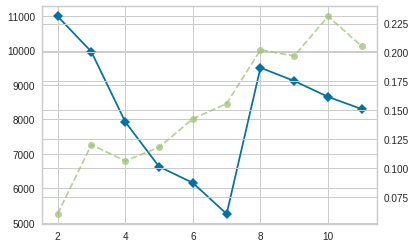

In [111]:
#elbow method visualization
visualizer = KElbowVisualizer(KMeans(), k=(2,12))
print(visualizer.fit(df1))